<h1 style="color: #006400;">Creating a Machine Learning Model</h1>
<h3 style="color: #8b5e3c;">Applying machine learning to create labels for our data</h3>
<p style="color: #8b5e3c;">Mathias Galvan</p>

<h2 style="color: #006400;"> Loading the Data </h2>

In [2]:
import pandas as pd
import seaborn as sns
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.decomposition import TruncatedSVD
from sklearn.cluster import MiniBatchKMeans, Birch
from sklearn.pipeline import Pipeline

acc_game_seat_2023 = pd.read_csv(r'/Users/galvanm/python/BucksHackathon25/BucksDatasets/ALGLSL_2023.csv')
acc_game_seat_2024 = pd.read_csv(r'/Users/galvanm/python/BucksHackathon25/BucksDatasets/ALGLSL_2024.csv')

acc_game_seat_2023.head()

,Unnamed: 0.1,Season_x,AccountNumber,Game,GameDate,GameTier,Giveaway,Unnamed: 0,Season_y,SingleGameTickets,PartialPlanTickets,GroupTickets,STM,AvgSpend,GamesAttended,FanSegment,DistanceToArena,BasketballPropensity,SocialMediaEngagement,GiveawayLabel
0,0,2023,1,2024-01-24 Cleveland Cavaliers,2024-01-24,D,Bucket Cap,0,2023,0,0,0,0,467.0,0,F,12.0,872.0,Low,1
1,1,2023,1,2024-01-24 Cleveland Cavaliers,2024-01-24,D,Bucket Cap,0,2023,0,0,0,0,467.0,0,F,12.0,872.0,Low,1
2,2,2023,1,2024-01-24 Cleveland Cavaliers,2024-01-24,D,Bucket Cap,0,2023,0,0,0,0,467.0,0,F,12.0,872.0,Low,1
3,3,2023,1,2024-01-24 Cleveland Cavaliers,2024-01-24,D,Bucket Cap,0,2023,0,0,0,0,467.0,0,F,12.0,872.0,Low,1
4,4,2023,1,2024-01-24 Cleveland Cavaliers,2024-01-24,D,Bucket Cap,0,2023,0,0,0,0,467.0,0,F,12.0,872.0,Low,1


In [3]:
acc_game_seat_2024.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 419114 entries, 0 to 419113
Data columns (total 20 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   Unnamed: 0.1           419114 non-null  int64  
 1   Season_x               419114 non-null  int64  
 2   AccountNumber          419114 non-null  int64  
 3   Game                   419114 non-null  object 
 4   GameDate               419114 non-null  object 
 5   GameTier               419114 non-null  object 
 6   Giveaway               81453 non-null   object 
 7   Unnamed: 0             419114 non-null  int64  
 8   Season_y               419114 non-null  int64  
 9   SingleGameTickets      419114 non-null  int64  
 10  PartialPlanTickets     419114 non-null  int64  
 11  GroupTickets           419114 non-null  int64  
 12  STM                    419114 non-null  int64  
 13  AvgSpend               419114 non-null  float64
 14  GamesAttended          419114 non-nu

In [4]:
acc_game_seat_2024.describe()

,Unnamed: 0.1,Season_x,AccountNumber,Unnamed: 0,Season_y,SingleGameTickets,PartialPlanTickets,GroupTickets,STM,AvgSpend,GamesAttended,DistanceToArena,BasketballPropensity,GiveawayLabel
count,419114.000000,419114.0,419114.000000,419114.000000,419114.0,419114.000000,419114.000000,419114.000000,419114.000000,419114.000000,419114.000000,419114.000000,419114.000000,419114.000000
mean,209556.500000,2024.0,23261.367432,24712.897918,2024.0,1.784171,2.815208,321.364774,0.618669,150.222570,4.064329,88.305063,763.280246,0.194346
std,120987.934697,0.0,8334.410383,7752.456993,0.0,13.966961,11.093028,3220.317113,0.485714,184.315993,5.341763,263.293279,195.331212,0.395697
min,0.000000,2024.0,2.000000,15667.000000,2024.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,125.000000,0.000000
25%,104778.250000,2024.0,17548.000000,18313.000000,2024.0,0.000000,0.000000,0.000000,0.000000,56.000000,0.000000,4.000000,612.000000,0.000000
50%,209556.500000,2024.0,21585.000000,22453.000000,2024.0,0.000000,0.000000,0.000000,1.000000,101.275000,1.000000,13.000000,831.000000,0.000000
75%,314334.750000,2024.0,28375.000000,29428.000000,2024.0,0.000000,0.000000,0.000000,1.000000,172.000000,6.000000,63.000000,937.000000,0.000000
max,419113.000000,2024.0,43028.000000,44210.000000,2024.0,288.000000,120.000000,37200.000000,1.000000,2716.000000,23.000000,4231.000000,993.000000,1.000000


In [5]:
acc_game_seat_2024['GiveawayLabel'].astype('category')
acc_game_seat_2024['STM'].astype('category')
acc_game_seat_2024['SocialMediaEngagement'].astype('category')
acc_game_seat_2024['GameTier'].astype('category')

acc_game_seat_2023['GiveawayLabel'].astype('category')
acc_game_seat_2023['STM'].astype('category')
acc_game_seat_2023['SocialMediaEngagement'].astype('category')
acc_game_seat_2023['GameTier'].astype('category')

0        D
1        D
2        D
3        D
4        D
        ..
74765    D
74766    C
74767    C
74768    C
74769    A
Name: GameTier, Length: 74770, dtype: category
Categories (4, object): ['A', 'B', 'C', 'D']

In [6]:
num_features = [
    'BasketballPropensity',
    'DistanceToArena',
    'AvgSpend',
    'GamesAttended',
    'SingleGameTickets',
    'PartialPlanTickets',
    'GroupTickets'
]
cat_features = [
    'GiveawayLabel',
    'STM',
    'SocialMediaEngagement',
    'GameTier'
]
numeric_transformer = Pipeline([
    ('scaler', StandardScaler())
])
categorical_transformer = Pipeline([
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])
preprocessor = ColumnTransformer([
    ('num', numeric_transformer, num_features),
    ('cat', categorical_transformer, cat_features)
])
reducer = TruncatedSVD(n_components=10, random_state=42)


In [7]:
mbk_pipeline = Pipeline([
    ('prep', preprocessor),
    ('svd', reducer),
    ('cluster', MiniBatchKMeans(
        n_clusters=4,         
        batch_size=10000,     
        random_state=42
    ))
])

In [8]:
birch_pipeline = Pipeline([
    ('prep', preprocessor),
    ('svd', reducer),
    ('cluster', Birch(
        n_clusters=4,         
        threshold=0.5         
    ))
])

In [9]:
full_df = pd.concat([acc_game_seat_2023, acc_game_seat_2024], ignore_index=True)
X = full_df[num_features + cat_features]


In [10]:
mbk_pipeline.fit(X)
labels_mbk = mbk_pipeline.predict(X)
full_df['cluster_mbk'] = labels_mbk


In [11]:
birch_pipeline.fit(X)
labels_birch = birch_pipeline.predict(X)
full_df['cluster_birch'] = labels_birch



In [12]:
#view clusters
print(full_df['cluster_mbk'].unique())
print(full_df['cluster_birch'].unique())

[1 2 3 0]
[1 2 0 3]


<Figure size 640x480 with 0 Axes>

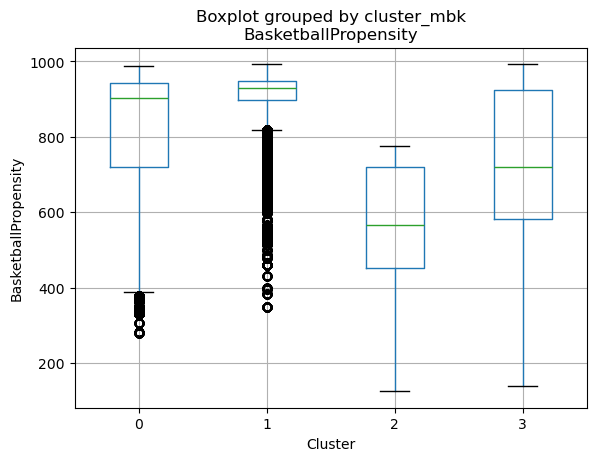

<Figure size 640x480 with 0 Axes>

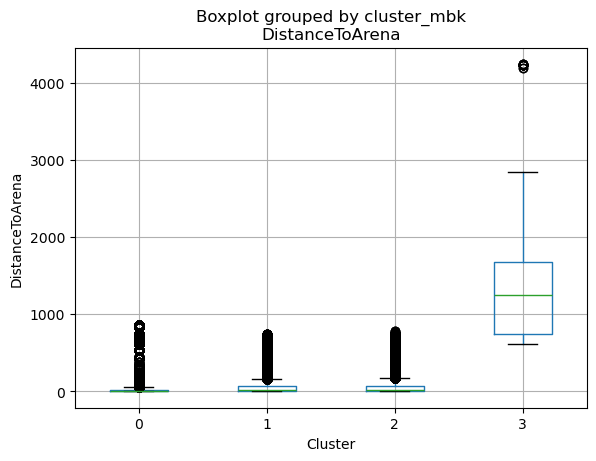

<Figure size 640x480 with 0 Axes>

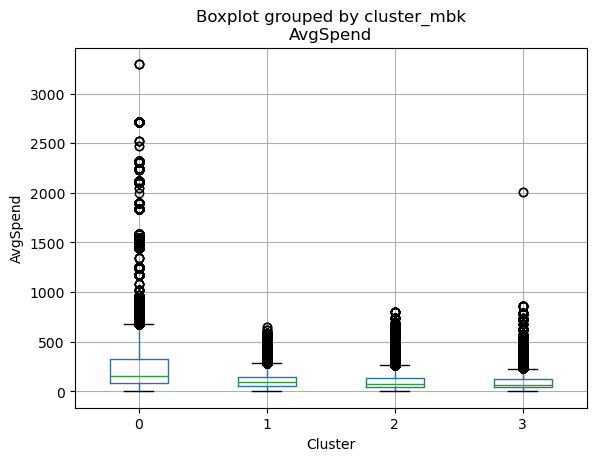

<Figure size 640x480 with 0 Axes>

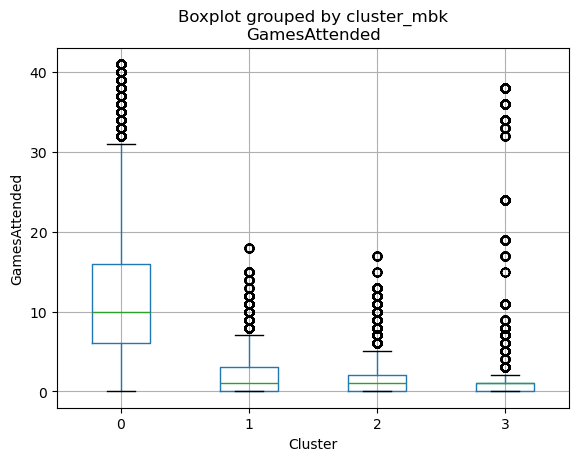

<Figure size 640x480 with 0 Axes>

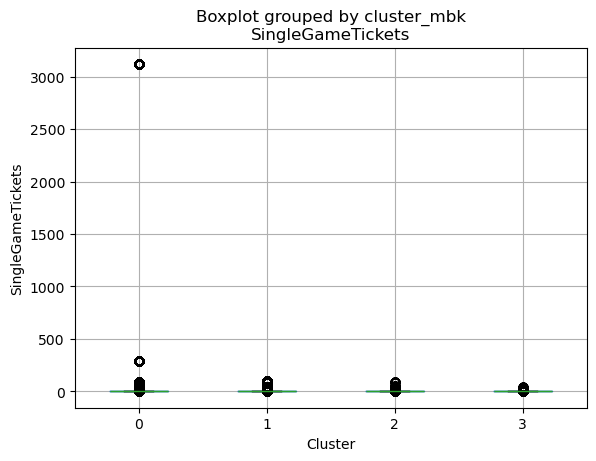

<Figure size 640x480 with 0 Axes>

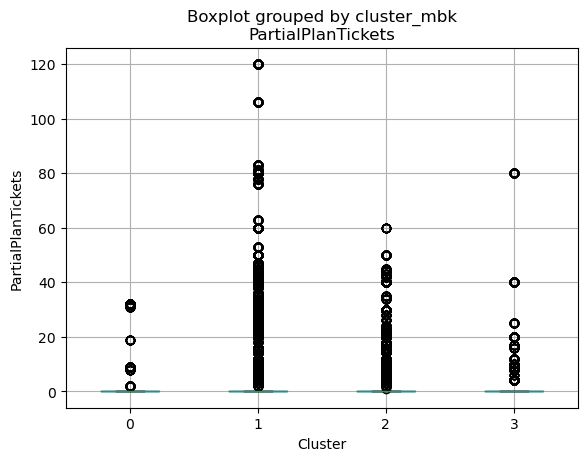

<Figure size 640x480 with 0 Axes>

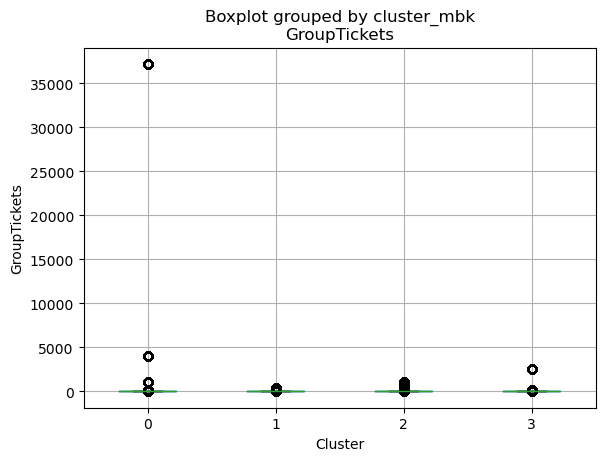

In [13]:
import matplotlib.pyplot as plt

for feat in num_features:
    plt.figure()
    full_df.boxplot(column=feat, by='cluster_mbk')
    plt.title(feat)
    plt.xlabel('Cluster')
    plt.ylabel(feat)
    plt.show()

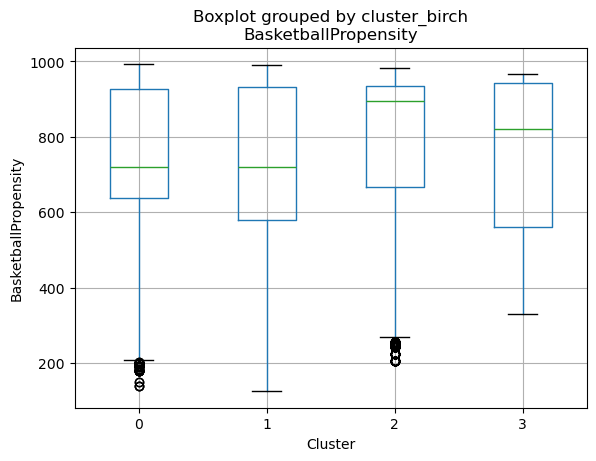

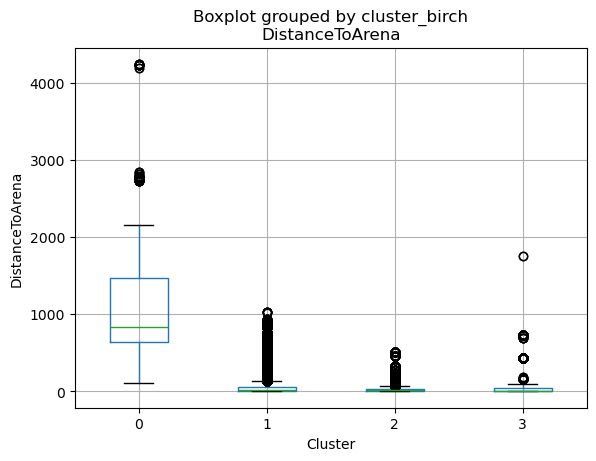

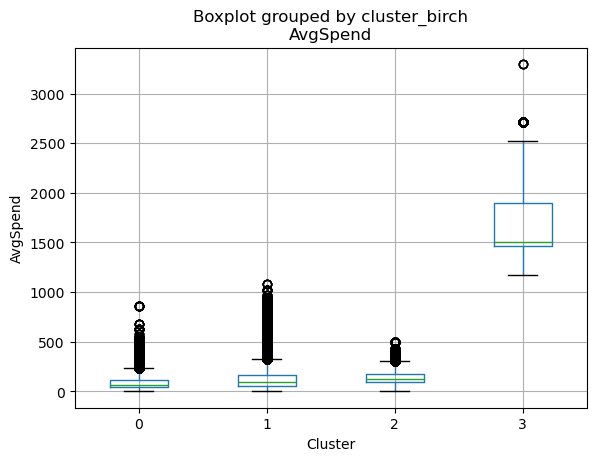

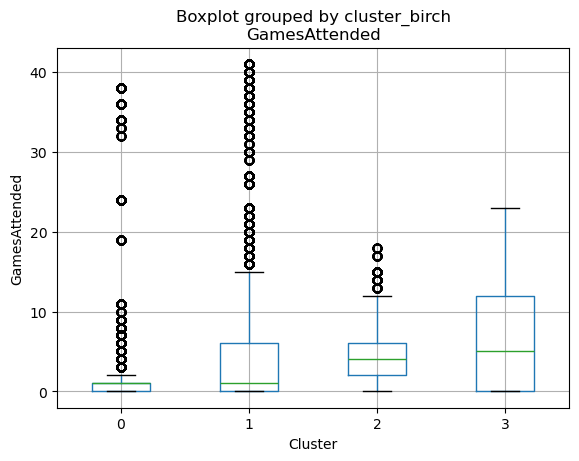

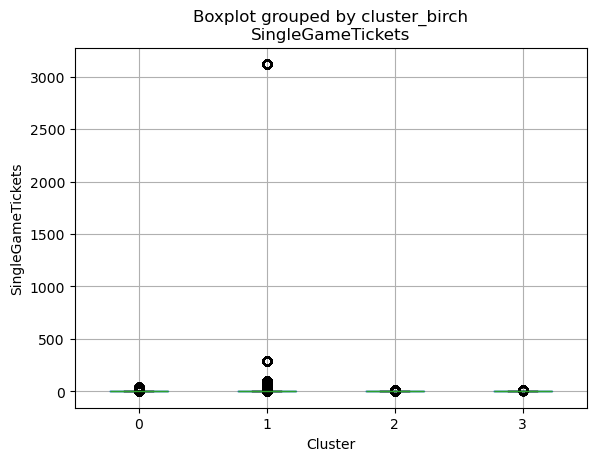

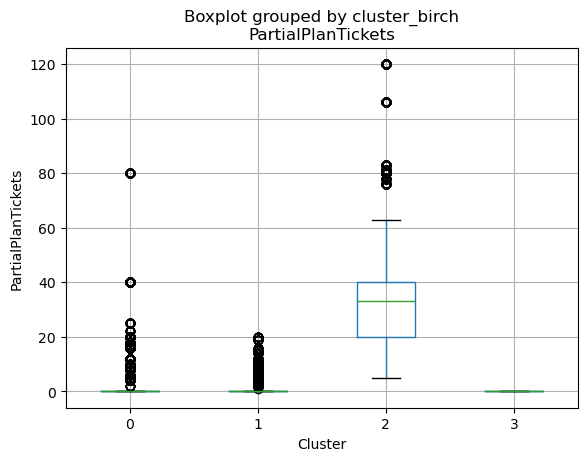

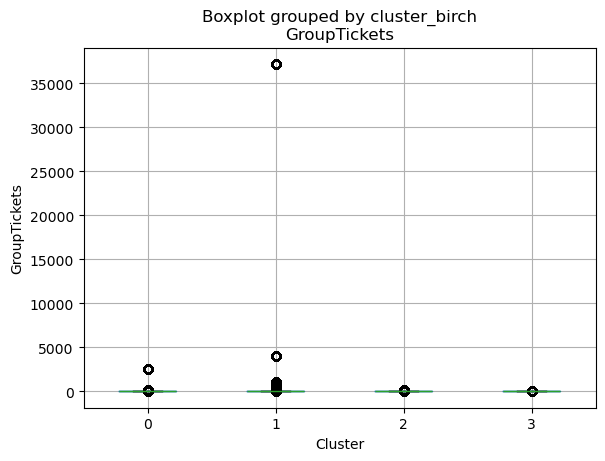

In [14]:
for feat in num_features:
    full_df.boxplot(column=feat, by='cluster_birch')
    plt.title(feat)
    plt.xlabel('Cluster')
    plt.ylabel(feat)
    plt.show()

In [15]:
birch_pipeline.fit(X)
cluster_labels = birch_pipeline.named_steps['cluster'].labels_

viz_pipeline = Pipeline([
    ('prep', preprocessor),
    ('svd2', TruncatedSVD(n_components=2, random_state=42))
])
coords_2d = viz_pipeline.fit_transform(X)


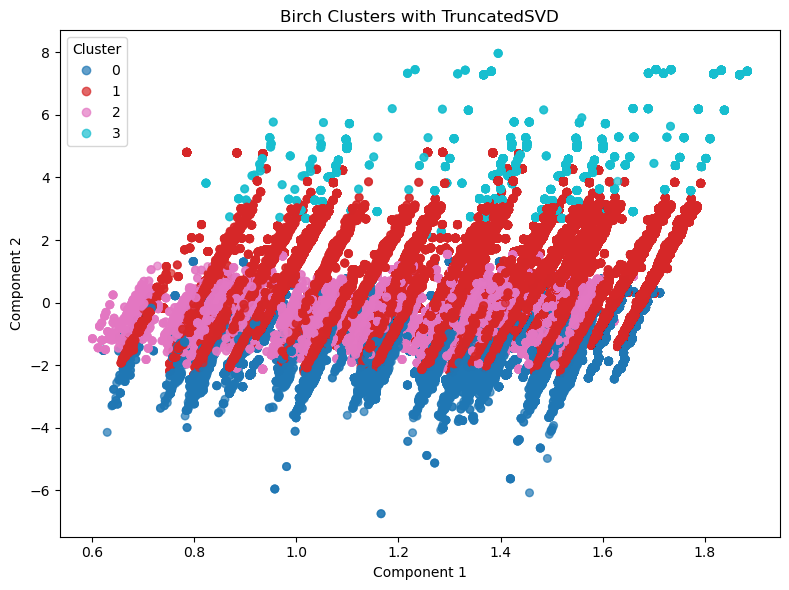

In [16]:
plt.figure(figsize=(8,6))
scatter = plt.scatter(
    coords_2d[:,0],
    coords_2d[:,1],
    c=cluster_labels,
    cmap='tab10',
    s=30,
    alpha=0.7
)
plt.title('Birch Clusters with TruncatedSVD')
plt.xlabel('Component 1')
plt.ylabel('Component 2')
plt.legend(
    *scatter.legend_elements(),
    title='Cluster'
)
sns.set_style( {'figure.facecolor': '#EEE1C6'})

plt.tight_layout()
plt.show()